In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
data = pd.read_csv('data/bank.csv', sep = ';', engine = 'python')

In [10]:
type(data)

pandas.core.frame.DataFrame

In [11]:
data

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no
5,35,management,single,tertiary,no,747,no,no,cellular,23,feb,141,2,176,3,failure,no
6,36,self-employed,married,tertiary,no,307,yes,no,cellular,14,may,341,1,330,2,other,no
7,39,technician,married,secondary,no,147,yes,no,cellular,6,may,151,2,-1,0,unknown,no
8,41,entrepreneur,married,tertiary,no,221,yes,no,unknown,14,may,57,2,-1,0,unknown,no
9,43,services,married,primary,no,-88,yes,yes,cellular,17,apr,313,1,147,2,failure,no


In [12]:
print(data)

      age            job   marital  education default  balance housing loan  \
0      30     unemployed   married    primary      no     1787      no   no   
1      33       services   married  secondary      no     4789     yes  yes   
2      35     management    single   tertiary      no     1350     yes   no   
3      30     management   married   tertiary      no     1476     yes  yes   
4      59    blue-collar   married  secondary      no        0     yes   no   
5      35     management    single   tertiary      no      747      no   no   
6      36  self-employed   married   tertiary      no      307     yes   no   
7      39     technician   married  secondary      no      147     yes   no   
8      41   entrepreneur   married   tertiary      no      221     yes   no   
9      43       services   married    primary      no      -88     yes  yes   
10     39       services   married  secondary      no     9374     yes   no   
11     43         admin.   married  secondary      n

In [13]:
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


Input variables:
# bank client data:
- age (numeric)
- job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
- marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
- education (categorical:'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
- default: has credit in default? (categorical: 'no','yes','unknown')
- housing: has housing loan? (categorical: 'no','yes','unknown')
- loan: has personal loan? (categorical: 'no','yes','unknown')

# related with the last contact of the current campaign:
- contact: contact communication type (categorical: 'cellular','telephone') 
- month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
- duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

# other attributes:
- campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
- pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
- previous: number of contacts performed before this campaign and for this client (numeric)
- poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

# social and economic context attributes
- emp.var.rate: employment variation rate - quarterly indicator (numeric)
- cons.price.idx: consumer price index - monthly indicator (numeric) 
- cons.conf.idx: consumer confidence index - monthly indicator (numeric) 
- euribor3m: euribor 3 month rate - daily indicator (numeric)
- nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
- y - has the client subscribed a term deposit? (binary: 'yes','no')

In [14]:
print(data.shape)

(4521, 17)


In [15]:
print(data.columns)

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')


In [16]:
data.describe()

,age,balance,day,duration,campaign,pdays,previous
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,15.915284,263.961292,2.793630,39.766645,0.542579
std,10.576211,3009.638142,8.247667,259.856633,3.109807,100.121124,1.693562
min,19.000000,-3313.000000,1.000000,4.000000,1.000000,-1.000000,0.000000
25%,33.000000,69.000000,9.000000,104.000000,1.000000,-1.000000,0.000000
50%,39.000000,444.000000,16.000000,185.000000,2.000000,-1.000000,0.000000
75%,49.000000,1480.000000,21.000000,329.000000,3.000000,-1.000000,0.000000
max,87.000000,71188.000000,31.000000,3025.000000,50.000000,871.000000,25.000000


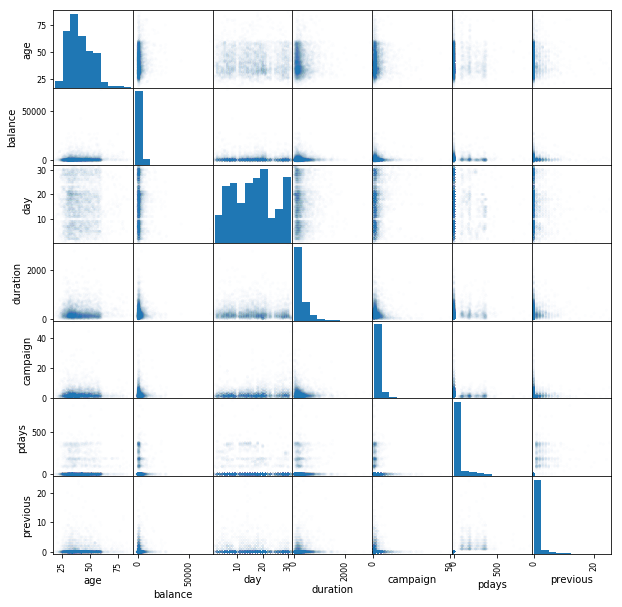

In [18]:
from pandas.plotting import scatter_matrix
scatter_matrix(data, alpha = .01, figsize = (10, 10))
pass

In [19]:
data.corr()

,age,balance,day,duration,campaign,pdays,previous
age,1.000000,0.083820,-0.017853,-0.002367,-0.005148,-0.008894,-0.003511
balance,0.083820,1.000000,-0.008677,-0.015950,-0.009976,0.009437,0.026196
day,-0.017853,-0.008677,1.000000,-0.024629,0.160706,-0.094352,-0.059114
duration,-0.002367,-0.015950,-0.024629,1.000000,-0.068382,0.010380,0.018080
campaign,-0.005148,-0.009976,0.160706,-0.068382,1.000000,-0.093137,-0.067833
pdays,-0.008894,0.009437,-0.094352,0.010380,-0.093137,1.000000,0.577562
previous,-0.003511,0.026196,-0.059114,0.018080,-0.067833,0.577562,1.000000


In [20]:
data.describe(include = ['object'])

,job,marital,education,default,housing,loan,contact,month,poutcome,y
count,4521,4521,4521,4521,4521,4521,4521,4521,4521,4521
unique,12,3,4,2,2,2,3,12,4,2
top,management,married,secondary,no,yes,no,cellular,may,unknown,no
freq,969,2797,2306,4445,2559,3830,2896,1398,3705,4000


In [21]:
data.describe(include = 'all')

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
count,4521.000000,4521,4521,4521,4521,4521.000000,4521,4521,4521,4521.000000,4521,4521.000000,4521.000000,4521.000000,4521.000000,4521,4521
unique,NaN,12,3,4,2,NaN,2,2,3,NaN,12,NaN,NaN,NaN,NaN,4,2
top,NaN,management,married,secondary,no,NaN,yes,no,cellular,NaN,may,NaN,NaN,NaN,NaN,unknown,no
freq,NaN,969,2797,2306,4445,NaN,2559,3830,2896,NaN,1398,NaN,NaN,NaN,NaN,3705,4000
mean,41.170095,NaN,NaN,NaN,NaN,1422.657819,NaN,NaN,NaN,15.915284,NaN,263.961292,2.793630,39.766645,0.542579,NaN,NaN
std,10.576211,NaN,NaN,NaN,NaN,3009.638142,NaN,NaN,NaN,8.247667,NaN,259.856633,3.109807,100.121124,1.693562,NaN,NaN
min,19.000000,NaN,NaN,NaN,NaN,-3313.000000,NaN,NaN,NaN,1.000000,NaN,4.000000,1.000000,-1.000000,0.000000,NaN,NaN
25%,33.000000,NaN,NaN,NaN,NaN,69.000000,NaN,NaN,NaN,9.000000,NaN,104.000000,1.000000,-1.000000,0.000000,NaN,NaN
50%,39.000000,NaN,NaN,NaN,NaN,444.000000,NaN,NaN,NaN,16.000000,NaN,185.000000,2.000000,-1.000000,0.000000,NaN,NaN
75%,49.000000,NaN,NaN,NaN,NaN,1480.000000,NaN,NaN,NaN,21.000000,NaN,329.000000,3.000000,-1.000000,0.000000,NaN,NaN


In [3]:
categorical_columns = [c for c in data.columns if data[c].dtype.name == 'object']
numerical_columns   = [c for c in data.columns if data[c].dtype.name != 'object']
print(categorical_columns)
print(numerical_columns)

['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y']
['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']


In [4]:
data.dropna(axis = 0)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no
5,35,management,single,tertiary,no,747,no,no,cellular,23,feb,141,2,176,3,failure,no
6,36,self-employed,married,tertiary,no,307,yes,no,cellular,14,may,341,1,330,2,other,no
7,39,technician,married,secondary,no,147,yes,no,cellular,6,may,151,2,-1,0,unknown,no
8,41,entrepreneur,married,tertiary,no,221,yes,no,unknown,14,may,57,2,-1,0,unknown,no
9,43,services,married,primary,no,-88,yes,yes,cellular,17,apr,313,1,147,2,failure,no


In [5]:
data = data.dropna(axis = 0)

In [6]:
data.median(axis = 0)

age          39.0
balance     444.0
day          16.0
duration    185.0
campaign      2.0
pdays        -1.0
previous      0.0
dtype: float64

In [7]:
data[numerical_columns].count(axis = 0)

age         4521
balance     4521
day         4521
duration    4521
campaign    4521
pdays       4521
previous    4521
dtype: int64

In [9]:
data_describe = data.describe(include = [object])
for c in categorical_columns:
    data[c] = data[c].fillna(data_describe[c]['top'])

In [10]:
binary_columns    = [c for c in categorical_columns if data_describe[c]['unique'] == 2]
nonbinary_columns = [c for c in categorical_columns if data_describe[c]['unique'] > 2]
print(binary_columns, nonbinary_columns)

['default', 'housing', 'loan', 'y'] ['job', 'marital', 'education', 'contact', 'month', 'poutcome']


In [18]:
print(data['default'].unique())
data.at[data['default'] == 'no', 'default'] = 0
data.at[data['default'] == 'yes', 'default'] = 1

[0 1]


/home/zebrahead/Libs/anaconda3/lib/python3.6/site-packages/pandas/core/ops.py:1164: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


TypeError: invalid type comparison

In [12]:
print(data['housing'].unique())
data.at[data['housing'] == 'no', 'housing'] = 0
data.at[data['housing'] == 'yes', 'housing'] = 1

['no' 'yes']


In [ ]:
print(data['loan'].unique())
data.at[data['loan'] == 'no', 'loan'] = 0
data.at[data['loan'] == 'yes', 'loan'] = 1

In [16]:
print(data['y'].unique())
data.at[data['y'] == 'no', 'y'] = 0
data.at[data['y'] == 'yes', 'y'] = 1

['no' 'yes']


In [17]:
print(data)

      age            job   marital  education  default  balance  housing loan  \
0      30     unemployed   married    primary        0     1787        0   no   
1      33       services   married  secondary        0     4789        1  yes   
2      35     management    single   tertiary        0     1350        1   no   
3      30     management   married   tertiary        0     1476        1  yes   
4      59    blue-collar   married  secondary        0        0        1   no   
5      35     management    single   tertiary        0      747        0   no   
6      36  self-employed   married   tertiary        0      307        1   no   
7      39     technician   married  secondary        0      147        1   no   
8      41   entrepreneur   married   tertiary        0      221        1   no   
9      43       services   married    primary        0      -88        1  yes   
10     39       services   married  secondary        0     9374        1   no   
11     43         admin.   m

In [19]:
print(data['education'].unique())

['primary' 'secondary' 'tertiary' 'unknown']


#TODO Vectorise features